Exploring a dataset with information about patients. 
Consider next 8 features to predict the mortality rate:
1. Age
2. ОССН KiLLip
3. HBR (b)
4. Systolic AP(b)
5. Creatine in blood
6. EF Percentage
7. White blood cells count
8. Glucose

# 1. Import required libraries and load the dataset

In [20]:
import numpy as np
import pandas as pd
from IPython.display import display

In [21]:
# Load dataset
raw_data = pd.read_excel('./import/DataSet_V47.xlsx')

columns_in_data = ['Age', 
           'ОССН KiLLip', 
           'ЧСС (b)', 
           'Систолическое АД(b)', 
           'Креатинин', 
           'EF%',
           'Лейкоциты(b)',
           'Глюкоза(a)',
           'начало операции',
           'Дата операции в БД',
           'дата выписки',
           'дата смерти',
           'Исход заболевания']

data=raw_data.loc[(raw_data['STEMI']== 'Да')  & 
                   (raw_data['Наличие в БД']== 'Да')  & 
                  (raw_data['Наличие в файле']== 'Да') &
                   (raw_data['ЧКВ']== 'Да'),
                   columns_in_data]

columns_to_check = ['Age',
                   'ЧСС (b)', 
                   'Систолическое АД(b)', 
                   'Креатинин',
                   'EF%', 
                   'Лейкоциты(b)',  
                   'Глюкоза(a)']

data_no_nan = data.dropna(subset=columns_to_check)

data_no_nan_copy = data_no_nan.copy()
for col_name in ['Дата операции в БД', 'дата выписки', 'дата смерти']:
    new_col_name = f"{col_name}_parsed"
    data_no_nan_copy[new_col_name] = pd.to_datetime(data_no_nan_copy[col_name], errors='coerce')

query_expression = "(not `дата смерти`.isnull() and `Исход заболевания` != 'умер')"

# Applying De Morgan's laws to the query
query_expression_2 = "(`дата смерти`.isnull() or `Исход заболевания` == 'умер')"

# Drop rows that satisfy the query expression
clean_data = data_no_nan_copy.query(query_expression_2)

mask = (
    (clean_data['дата смерти_parsed'].notna()) & 
                (clean_data['дата смерти_parsed'] - clean_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
    | ((clean_data['дата смерти_parsed'].isna()) & 
                (clean_data['Исход заболевания'] == 'умер') & 
                (clean_data['дата выписки_parsed'].notna()) & 
                (clean_data['дата выписки_parsed'] - clean_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
        )
)

rows_to_keep = ~mask
ready_data = clean_data[rows_to_keep]
ready_data.describe()

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,62.359788,1.657407,74.564815,133.609788,106.298396,54.633598,11.305430,6.579134
std,10.892925,0.950490,14.805993,24.040857,50.914138,8.940425,3.988858,3.069784
min,26.000000,0.000000,30.000000,15.000000,3.830000,20.000000,0.100000,0.000000
25%,55.000000,1.000000,65.000000,120.000000,83.000000,49.000000,8.500000,5.107500
50%,63.000000,1.000000,72.000000,130.000000,98.755000,56.000000,10.700000,5.800000
75%,70.000000,2.000000,80.000000,150.000000,117.397500,61.000000,13.400000,6.982500
max,92.000000,4.000000,160.000000,240.000000,1354.000000,80.000000,38.800000,77.330000


# 2. Split the dataset into features and target.

In [22]:
X = ready_data[['Age', 
                        'ОССН KiLLip', 
                        'ЧСС (b)', 
                        'Систолическое АД(b)', 
                        'Креатинин', 
                        'EF%', 
                        'Лейкоциты(b)', 
                        'Глюкоза(a)']]
y = ready_data['Исход заболевания'].apply(lambda x: 1 if x == 'умер' else 0)

We want to consider hyper parameters, so we will use three different random_state parameters. 

In [23]:
random_states = [0, 25, 42]

## 3. GXBoost

In [29]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
import shap


feature_names = ["Age", "ОССН KiLLip", "HBR (b)", "Systolic AP(b)", "Creatine in blood", "EF Percentage", "White blood cells count", "Glucose"]

feature_importances = pd.DataFrame(index=feature_names)
shap_values_list = []

for random_state in random_states:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Define model
    model = xgb.XGBClassifier(eval_metric='logloss', random_state=random_state)

    # Define hyperparameters for grid search
    hyperparameter_grid = {
        'n_estimators': [10, 50, 100, 200], 
        'max_depth': [None, 2, 5, 10], 
        'learning_rate': [0.1, 0.01, 0.001],
        }

    # Define grid search
    grid_cv = GridSearchCV(estimator=model, 
                           param_grid=hyperparameter_grid,
                           cv=5,
                           scoring='roc_auc')

    # Execute grid search
    grid_cv.fit(X_train, y_train)

    # Display best parameters
    print(grid_cv.best_params_)

    # Retrain the model with the best parameters
    model = xgb.XGBClassifier(eval_metric='logloss',
                              random_state=random_state, 
                              n_estimators=grid_cv.best_params_['n_estimators'], 
                              max_depth=grid_cv.best_params_['max_depth'], 
                              learning_rate=grid_cv.best_params_['learning_rate'],
                              n_jobs=-1)

    model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate AUC-ROC score
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    print(f'AUC-ROC score for {random_state=}: {auc_roc}')

    # Calculate SHAP values
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    shap_values_list.append(shap_values.values)
    feature_importances[random_state] = model.feature_importances_
    feature_importances[str(random_state)+"_shap"] = np.mean(np.abs(shap_values.values), axis=0)

# Calculate mean feature importances and SHAP values
feature_importances['mean_importance'] = feature_importances[random_states].mean(axis=1)
feature_importances['mean_shap'] = feature_importances[[str(state) + "_shap" for state in random_states]].mean(axis=1)


{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}
AUC-ROC score for random_state=0: 0.8954104544638046
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
AUC-ROC score for random_state=25: 0.8657963185274109
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
AUC-ROC score for random_state=42: 0.8753418803418803


In [25]:
feature_importances

,0,0_shap,25,25_shap,42,42_shap,mean_importance,mean_shap
Age,0.076900,0.042850,0.082222,0.103335,0.101156,0.075525,0.086759,0.073903
ОССН KiLLip,0.123727,0.027189,0.151624,0.182237,0.144367,0.152896,0.139906,0.120774
HBR (b),0.093791,0.114391,0.110659,0.217178,0.133300,0.213953,0.112583,0.181841
Systolic AP(b),0.120519,0.037436,0.107386,0.060770,0.100338,0.046438,0.109414,0.048215
Creatine in blood,0.110259,0.041244,0.133275,0.123017,0.138822,0.112649,0.127452,0.092303
EF Percentage,0.224844,0.097163,0.148144,0.341483,0.154885,0.335248,0.175957,0.257965
White blood cells count,0.119639,0.027711,0.130163,0.044001,0.102384,0.103790,0.117396,0.058501
Glucose,0.130322,0.069193,0.136528,0.213765,0.124747,0.221291,0.130532,0.168083


In [26]:
import matplotlib.pyplot as plt

def plot_weights (feature_importances, column1, column2, label1, label2, title, num_digits=3):
    barWidth = 0.25

    r1 = np.arange(len(feature_importances[column1]))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(13, 6))
    bars1 = plt.barh(r1, feature_importances[column1], color='blue', height=barWidth, edgecolor='grey', label=label1)
    bars2 = plt.barh(r2, feature_importances[column2], color='orange', height=barWidth, edgecolor='grey', label=label2)

    plt.yticks([r + barWidth for r in range(len(feature_importances[column1]))], feature_importances.index)

    def add_values(bars):
        for bar in bars:
            width = bar.get_width()
            plt.text(width,               
                    bar.get_y() + bar.get_height() / 2.2 ,  
                    f"{width :.{num_digits}f}",  
                    ha='left', va='center')  


    add_values(bars1)
    add_values(bars2)

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

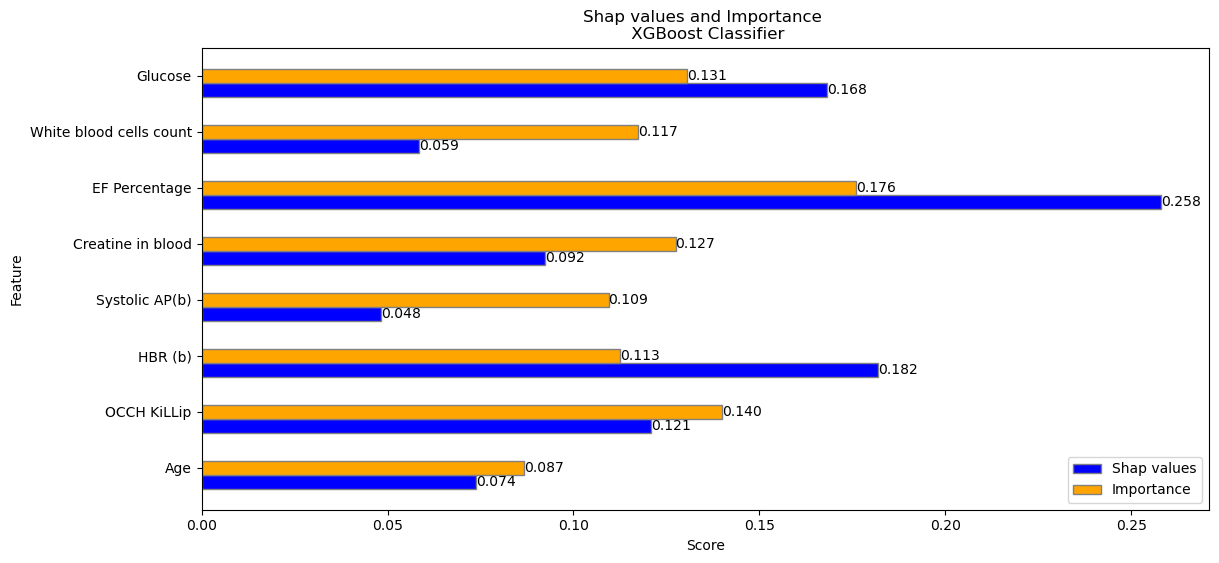

In [27]:
plot_weights(feature_importances, 
             column1='mean_shap', 
             column2='mean_importance', 
             label1='Shap values', 
             label2='Importance', 
             title='Shap values and Importance \n XGBoost Classifier',
             num_digits=3)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


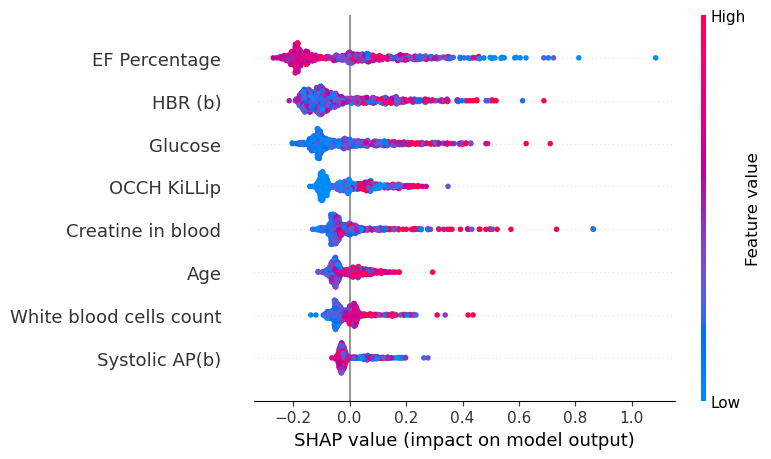

In [30]:
mean_shap_values = np.mean(shap_values_list, axis=0)
shap.summary_plot(mean_shap_values, X_test, feature_names=feature_names)